# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline of the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found in. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
#for math and padat structure
import pandas as pd
import numpy as np

#for modeling
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import itertools

# import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose as sd

#for visualizations
import matplotlib
import matplotlib.pyplot as plt
# from matplotlib.pylab import rcParams
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('zillow_data.csv')
display(df.head())
df.info()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06   ...     2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0   ...     1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0   ...      308000   310000   312500   
2         3  210400.0  212200.0  212200.0   ...      321000   320600   320200   
3         4  498100.0  500900.0  503100.0   ...     1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0   ...      119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [3]:
df.columns

Index(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank', '1996-04', '1996-05', '1996-06',
       ...
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04'],
      dtype='object', length=272)

# Step 2: Data Preprocessing

This step we deemed unnecessary as the function for reshaping simultaneously handles datetime conversion and dropping of NaNs.

In [4]:
# def get_datetimes(df):
#     return pd.to_datetime(df.columns.values[0:], format='%Y-%m')

In [5]:
# # changing column headers to datetime format
# col_labels = ['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName','SizeRank']
# dates = df.drop(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName','SizeRank'], axis=1)
# df_dates = get_datetimes(dates)
# for x in df_dates:
#     col_labels.append(x)
# df.columns = col_labels

# Step 3: Reshape from Wide to Long Format

In [6]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='Month', value_name='MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [7]:
dfm = melt_data(df)

In [8]:
display(dfm.head())
dfm.info()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank      Month  MeanValue  
0         1 1996-04-01   334200.0  
1         2 1996-04-01   235700.0  
2         3 1996-04-01   210400.0  
3         4 1996-04-01   498100.0  
4         5 1996-04-01    77300.0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3744704 entries, 0 to 3901594
Data columns (total 9 columns):
RegionID      int64
RegionName    int64
City          object
State         object
Metro         object
CountyName    object
SizeRank      int64
Month         datetime64[ns]
MeanValue     float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 285.7+ MB


### Step 3b: Selecting a region for investigation

Region = Atlanta, Georgia

In [9]:
ATL = dfm[(dfm.Metro == 'Atlanta') & (dfm.CountyName.isin(['Fulton','Dekalb','Cobb','Clayton']))].copy()
ATL.head()

RegionID  RegionName         City State    Metro CountyName  SizeRank  \
28      71067       30349    Riverdale    GA  Atlanta    Clayton        29   
213     70859       30080       Smyrna    GA  Atlanta       Cobb       214   
221     70842       30062     Marietta    GA  Atlanta       Cobb       222   
227     71050       30331      Atlanta    GA  Atlanta     Fulton       228   
254     70808       30022  Johns Creek    GA  Atlanta     Fulton       255   

         Month  MeanValue  
28  1996-04-01    90900.0  
213 1996-04-01   133000.0  
221 1996-04-01   150000.0  
227 1996-04-01    97100.0  
254 1996-04-01   206900.0

In [10]:
# Remove columns which are not helpful for data analysis
ATL.drop(['RegionID','City','State','Metro','CountyName','SizeRank'], axis=1, inplace=True)
ATL.reset_index(drop=True, inplace=True)
ATL.head()

RegionName      Month  MeanValue
0       30349 1996-04-01    90900.0
1       30080 1996-04-01   133000.0
2       30062 1996-04-01   150000.0
3       30331 1996-04-01    97100.0
4       30022 1996-04-01   206900.0

In [11]:
# See if any zipcodes are lacking observations
ATL.RegionName.value_counts()

30329    265
30004    265
30309    265
30213    265
30101    265
30005    265
30324    265
30316    265
30308    265
30268    265
30260    265
30084    265
30076    265
30068    265
30060    265
30327    265
30305    265
30319    265
30127    265
30087    265
30350    265
30342    265
30326    265
30294    265
30238    265
30126    265
30102    265
30062    265
30038    265
30030    265
        ... 
30339    265
30033    265
30009    265
30360    265
30328    265
30296    265
30152    265
30144    265
30080    265
30064    265
30008    265
30002    265
30363    265
30331    265
30307    265
30034    265
30058    265
30066    265
30082    265
30106    265
30306    265
30338    265
30067    265
30075    265
30291    265
30022    265
30168     58
30079     58
30032     58
30288     52
Name: RegionName, Length: 63, dtype: int64

In [12]:
# Removing zip codes lacking 265 observations
ATL = ATL[~ATL.RegionName.isin([30168,30079,30032,30288])]

# Step 4: EDA and Visualization

In [13]:
# font = {'weight':'bold', 'size': 14}
# matplotlib.rc('font', **font)
# NOTE: if visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [14]:
### WHY WON"T THIS CODE WORK!!!!

# for zipcode in atlanta.keys():
#     plt.figure(figsize=(15,4))
#     atlanta[zipcode].plot(title=zipcode)

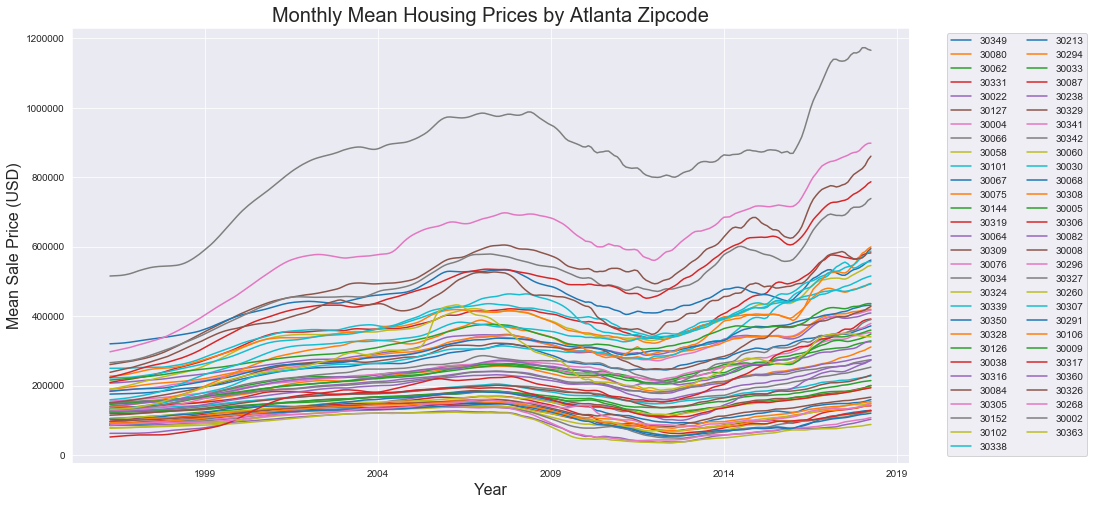

In [15]:
for zipcode in ATL.RegionName.unique():
    temp_df = ATL[ATL.RegionName == zipcode].set_index('Month')
    temp_df['MeanValue'].plot(figsize=(15,8), label=zipcode)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Mean Sale Price (USD)", fontsize=16)
plt.title("Monthly Mean Housing Prices by Atlanta Zipcode", fontsize=20);

Wonderful! It appears that each of the Atlanta zipcodes is capable of being plotted without throwing any errors.

#### Removing potentially confounding data

Looking at the graph above and thinking about recent history, we know that the housing crash of 2008 is the culprit behind the dip in housing price in the middle of our graph. Because we want to make business decisions based on post-crash trends. Therefore, we will build our models using only the data gathered after 2010 (2011-present) since this was when the housing market bottomed out. 

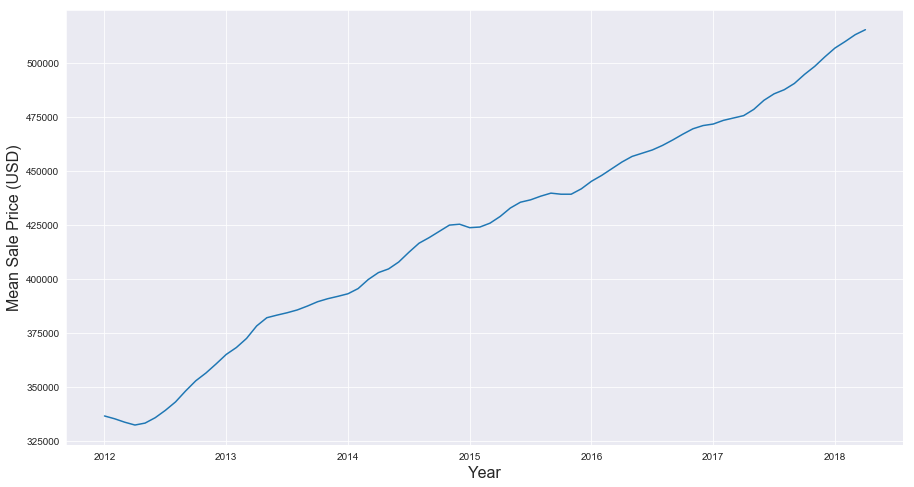

In [16]:
temp_df = ATL[(ATL.RegionName == 30339) & (ATL.Month >= '2012')].set_index('Month')
temp_df['MeanValue'].plot(figsize=(15,8), label=30342)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Mean Sale Price (USD)", fontsize=16);

# Step 5: ARIMA Modeling

Region: Atlanta

Best = Highest ROI with the lowest volatility since 2010 (after housing crash)

In [17]:
# Make a dictionary for each zipcode
atlanta = {}
for zipcode in ATL.RegionName.unique():
    temp = ATL[ATL.RegionName == zipcode].set_index('Month')
    temp.drop('RegionName', axis=1, inplace=True)
    atlanta[zipcode] = temp

In [18]:
atlanta_diff = {}
for key in list(atlanta.keys()):
    atlanta_diff[key] = atlanta[key].diff(periods=12).dropna()

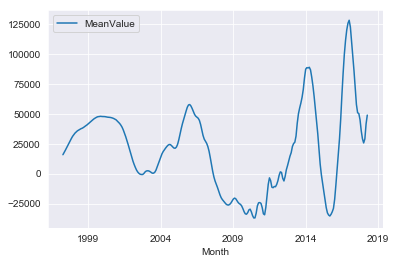

In [19]:
atlanta_diff[30342].plot()

In [20]:
def stationarity_check(TS, column_name, rolling_window=7):
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    rolmean = TS.rolling(window = rolling_window, center = False).mean()
    rolstd = TS.rolling(window = rolling_window, center = False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS[column_name]) # change the column name as required 
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    return None



In [21]:
# Log transform the values
ATL_log ={}
for zipcode in atlanta.keys():
    ATL_log[zipcode] = np.log(atlanta[zipcode])

C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


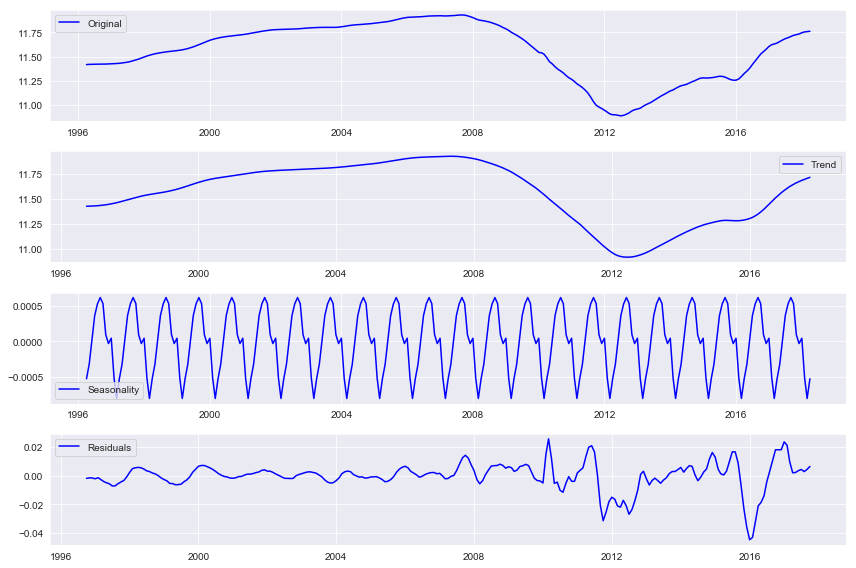

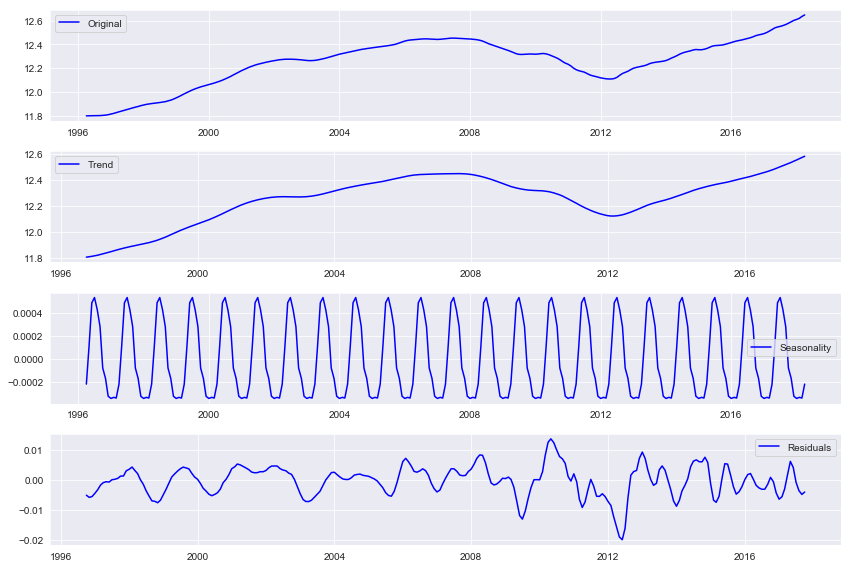

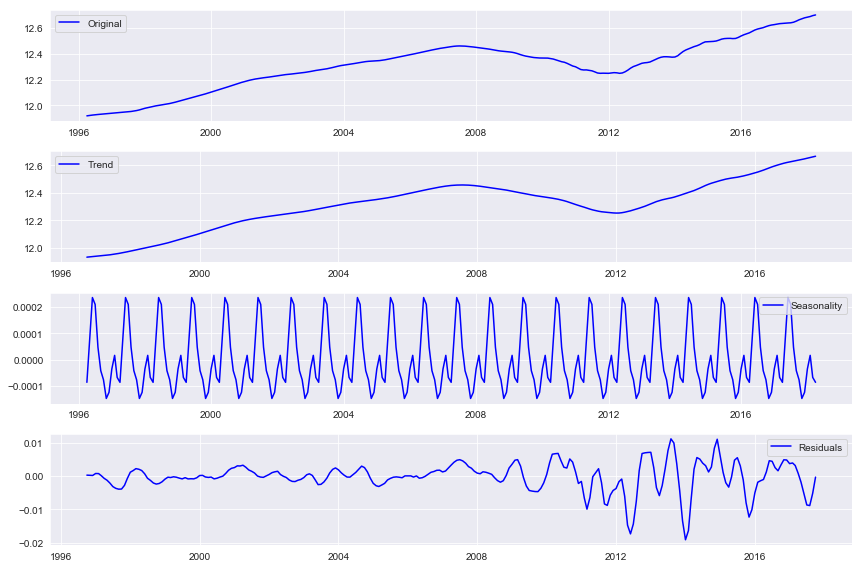

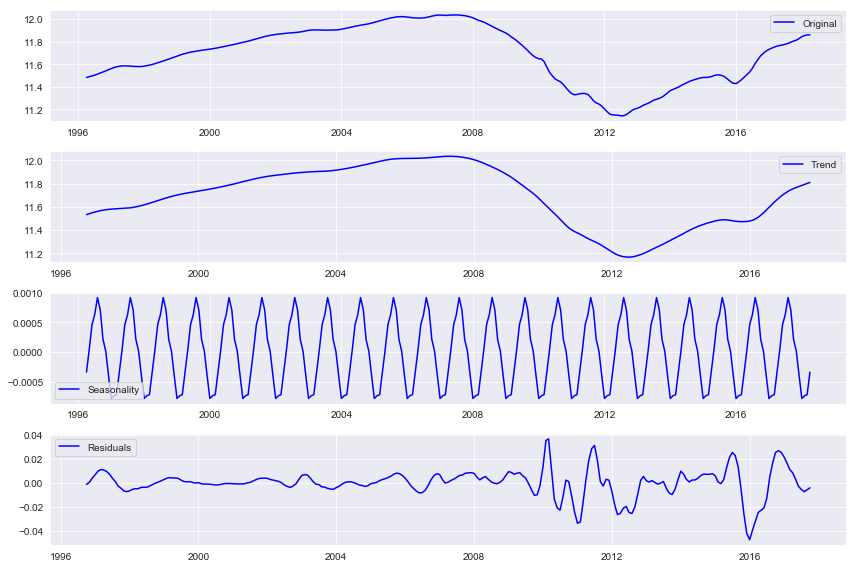

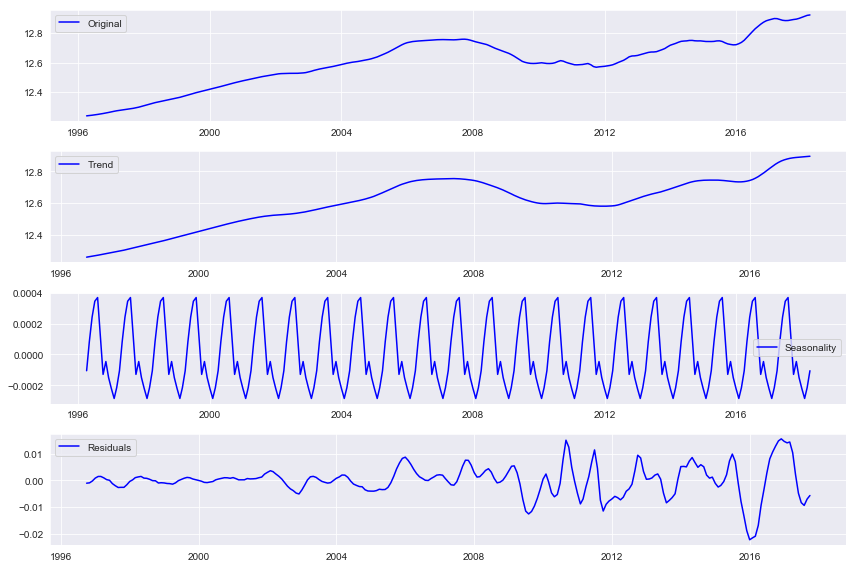

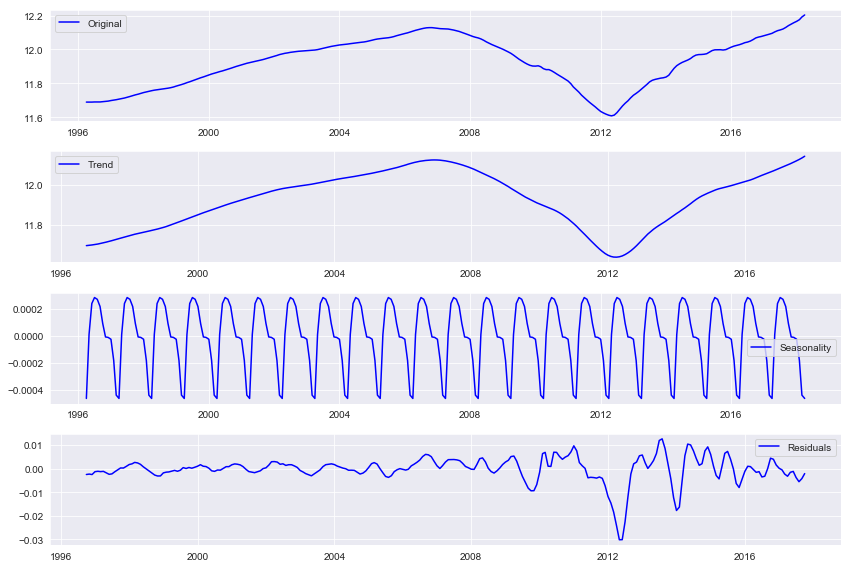

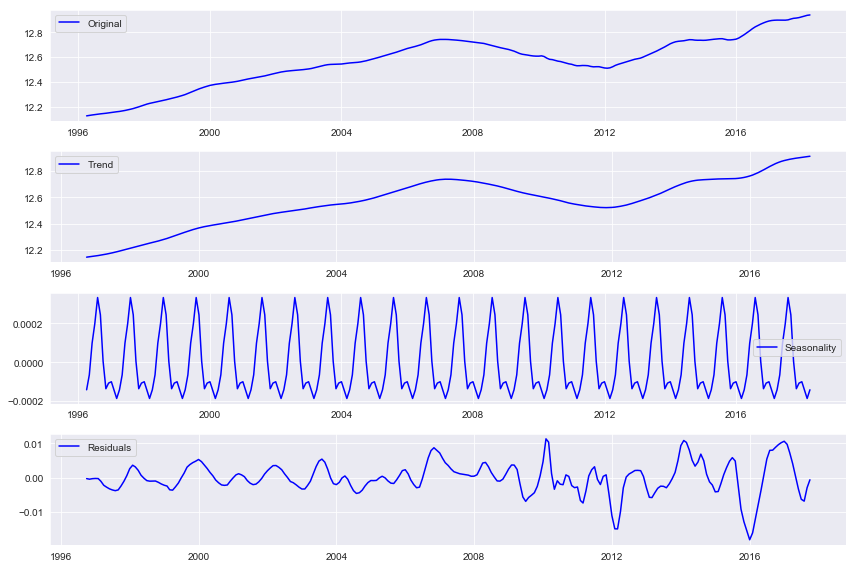

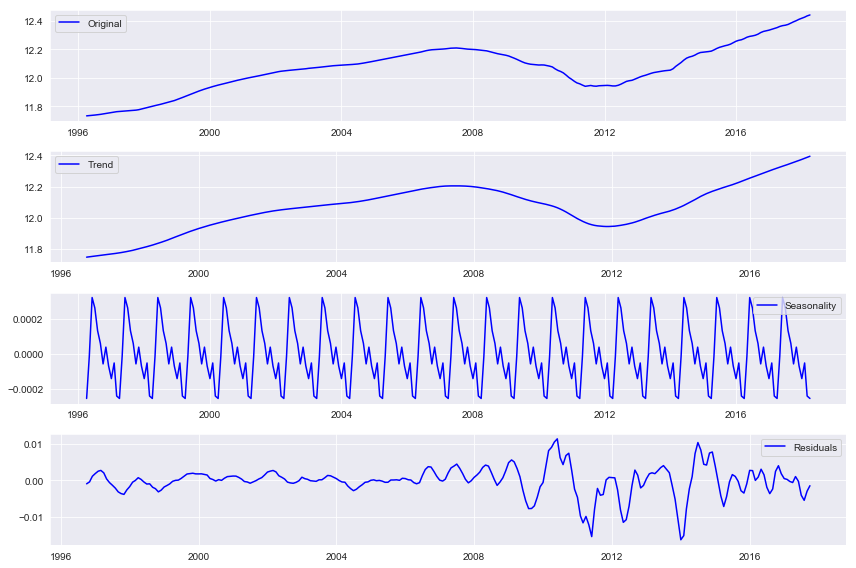

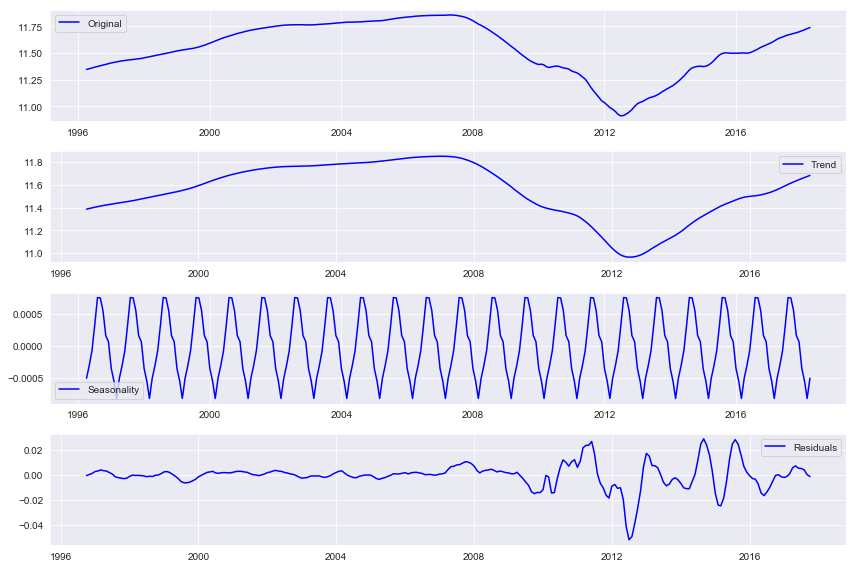

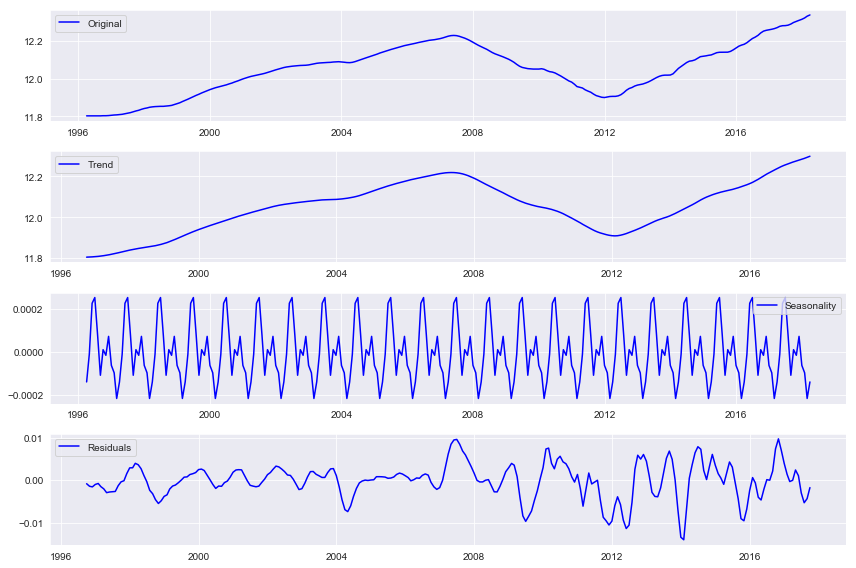

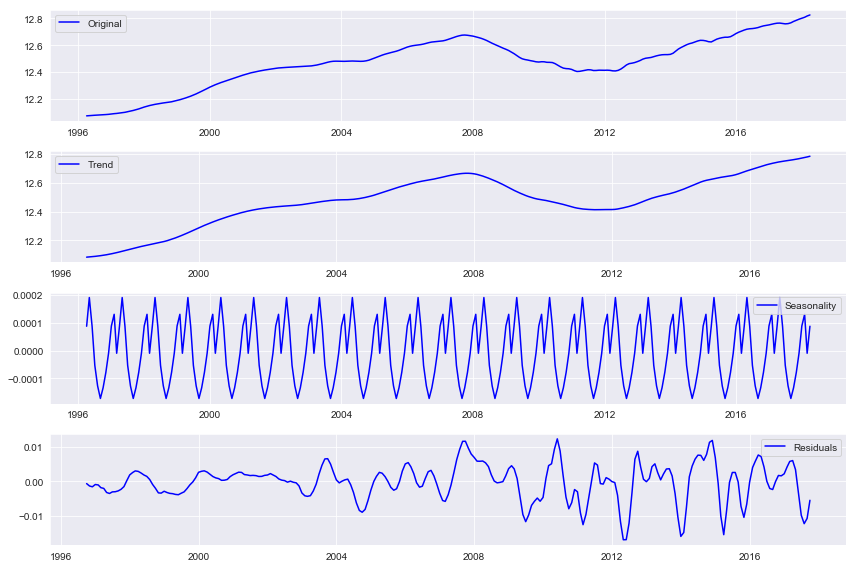

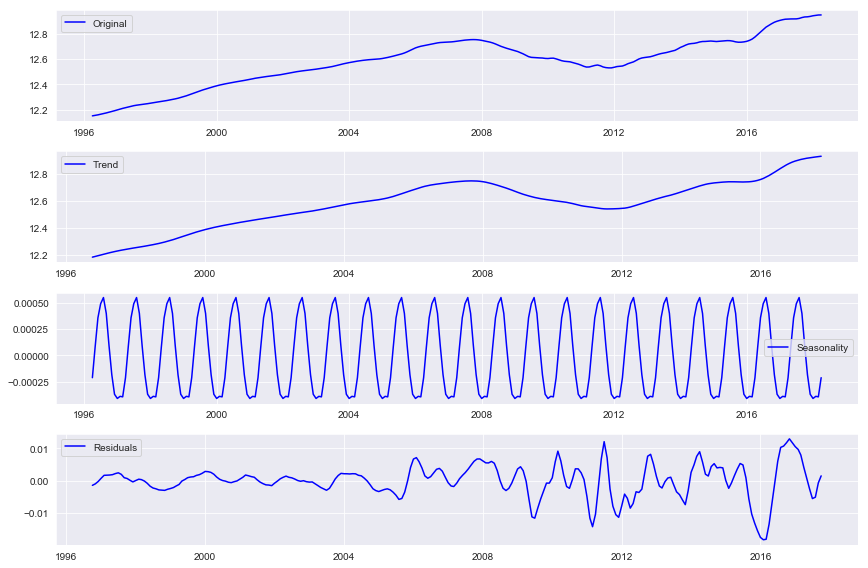

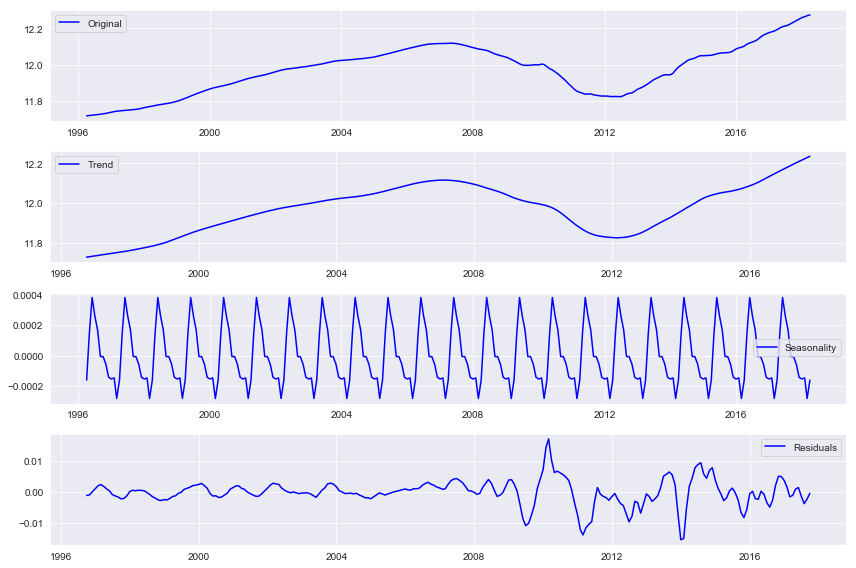

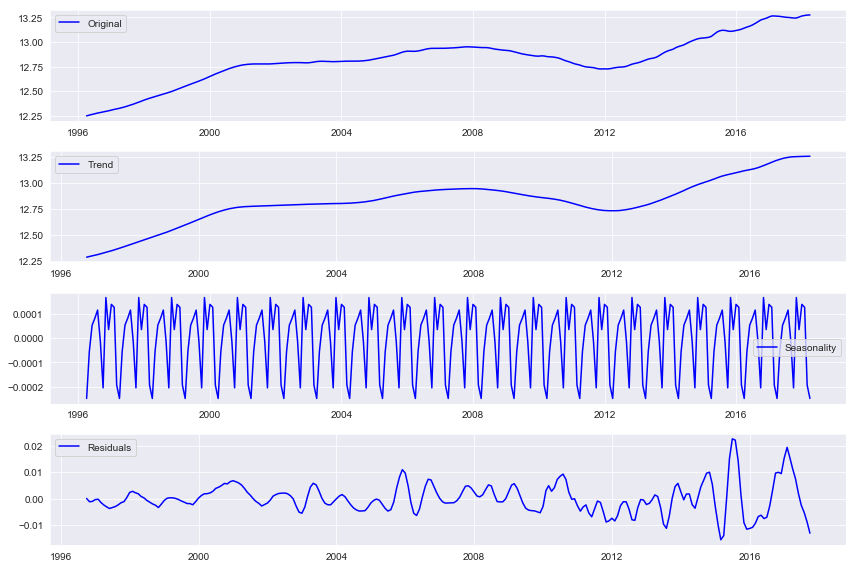

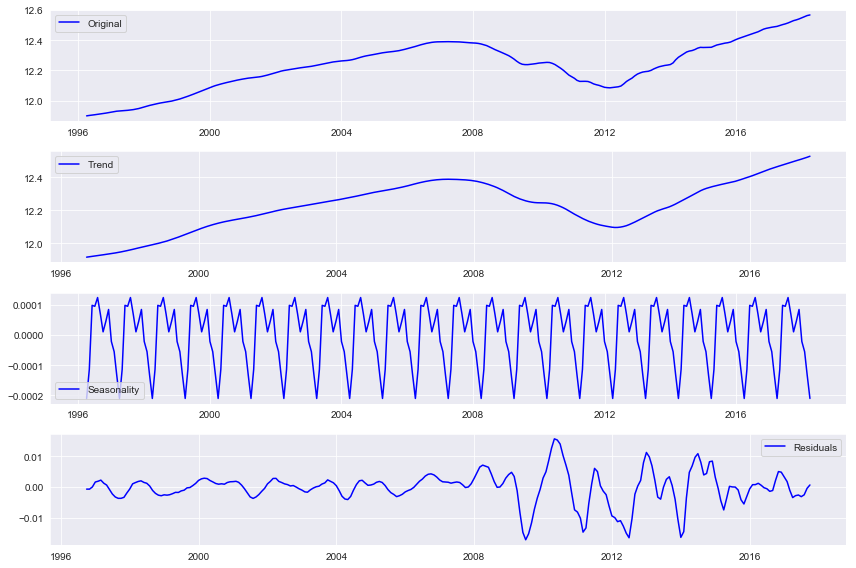

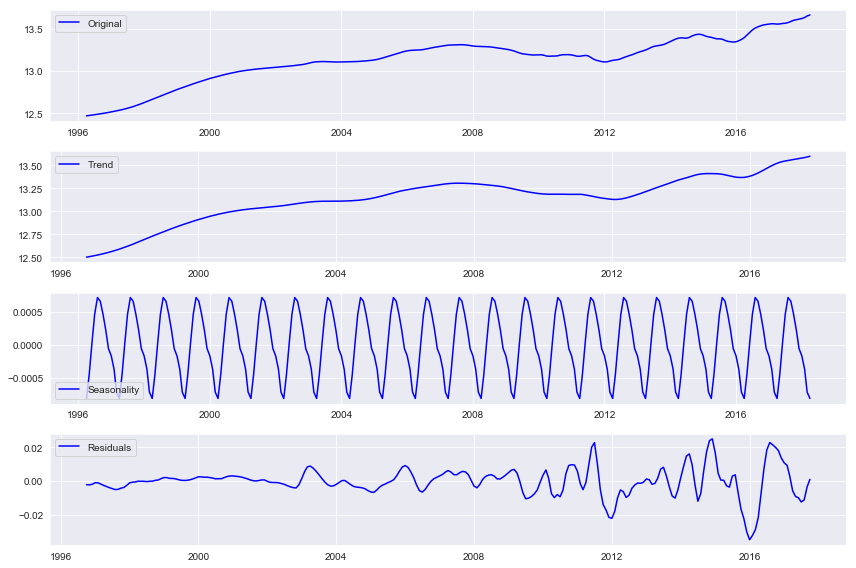

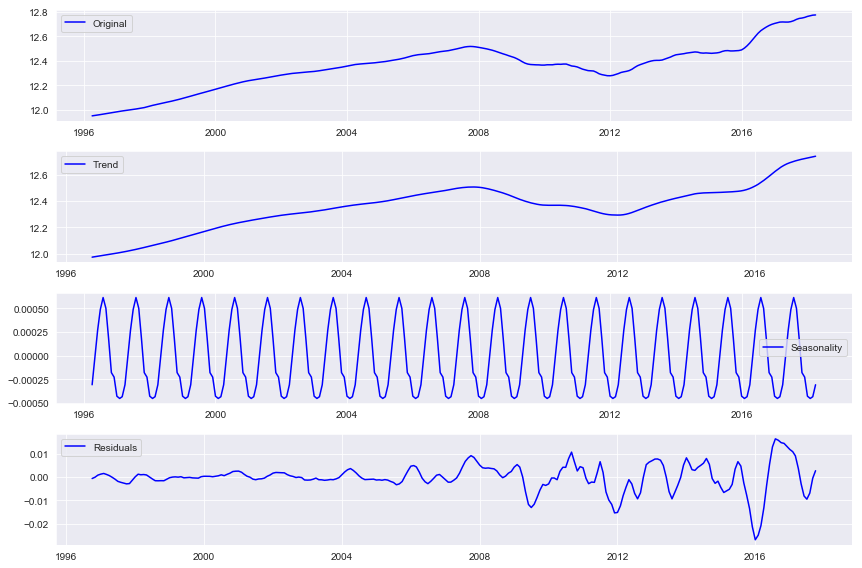

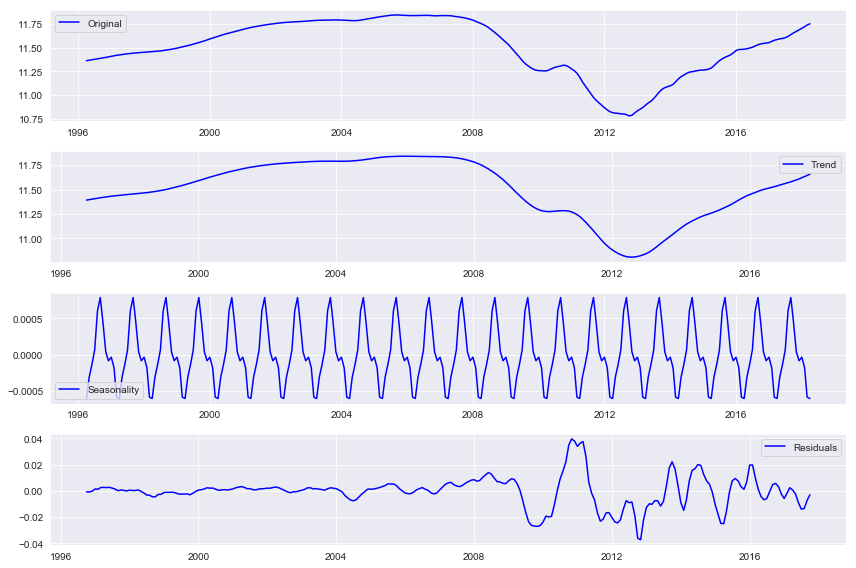

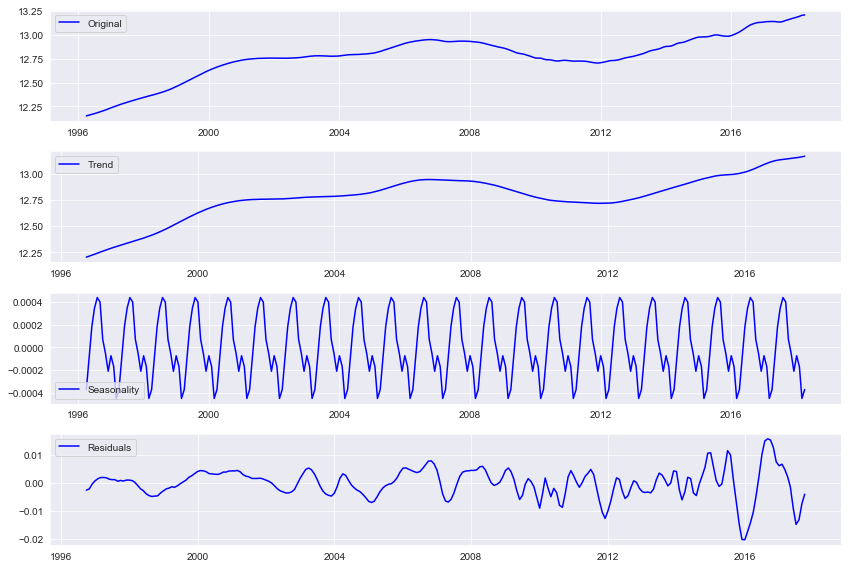

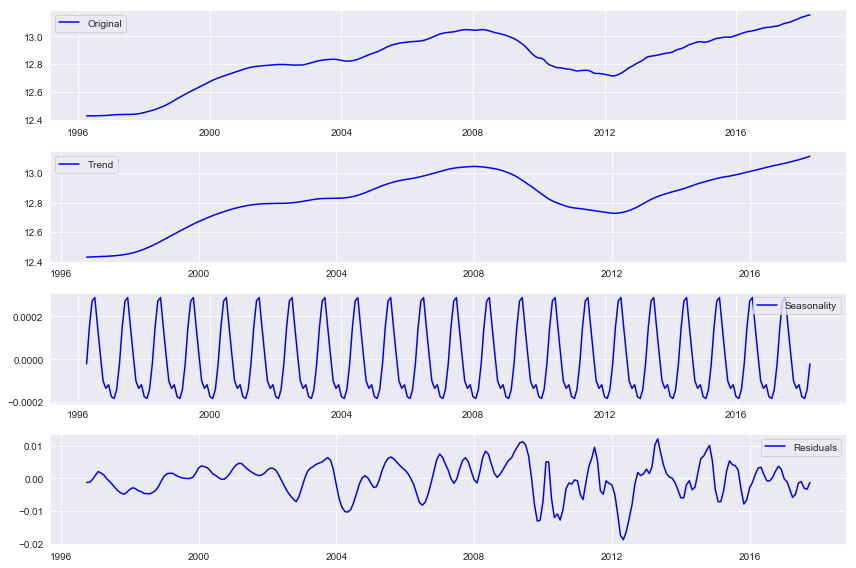

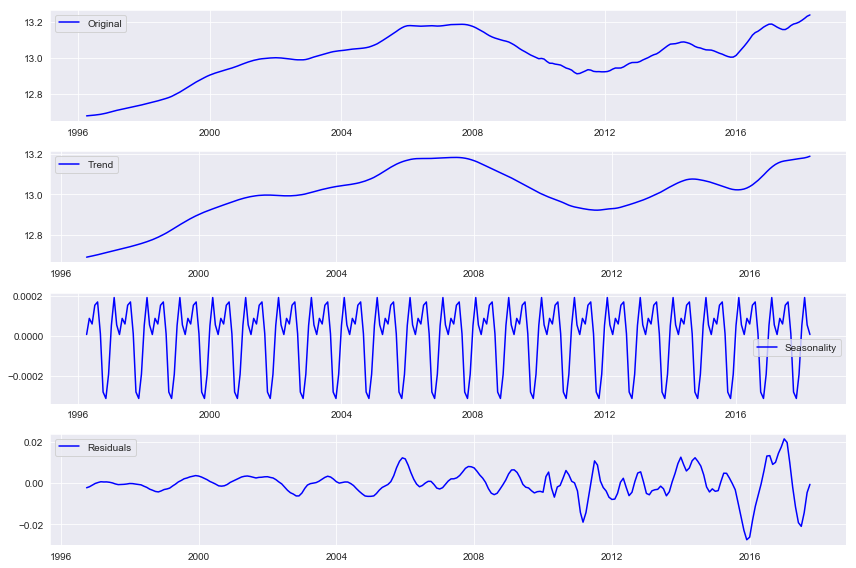

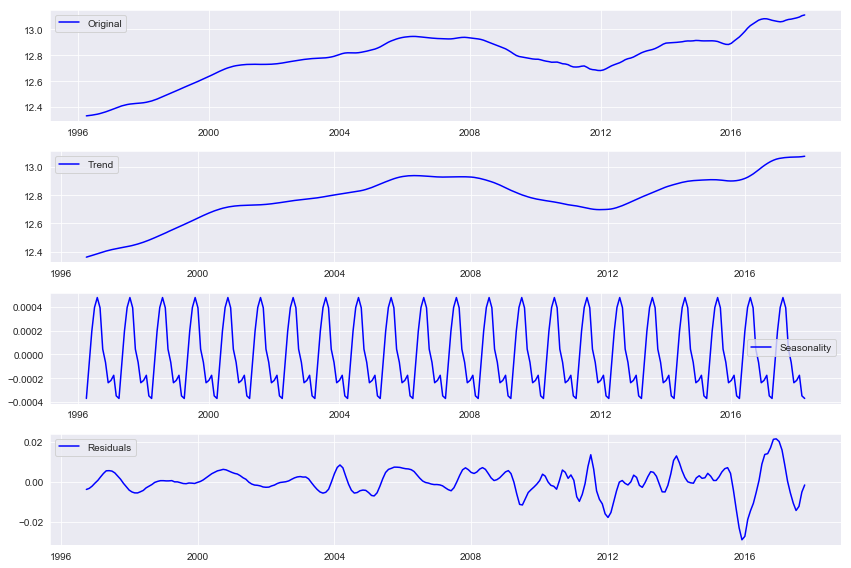

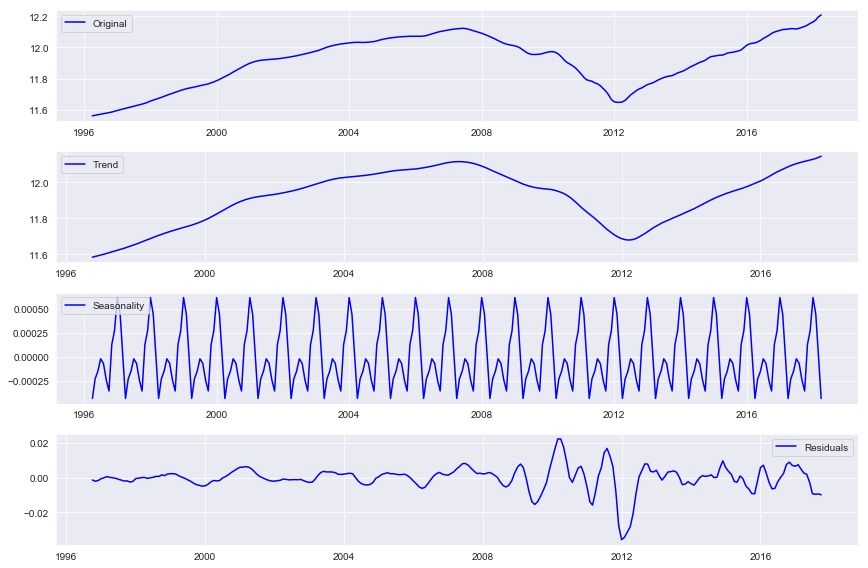

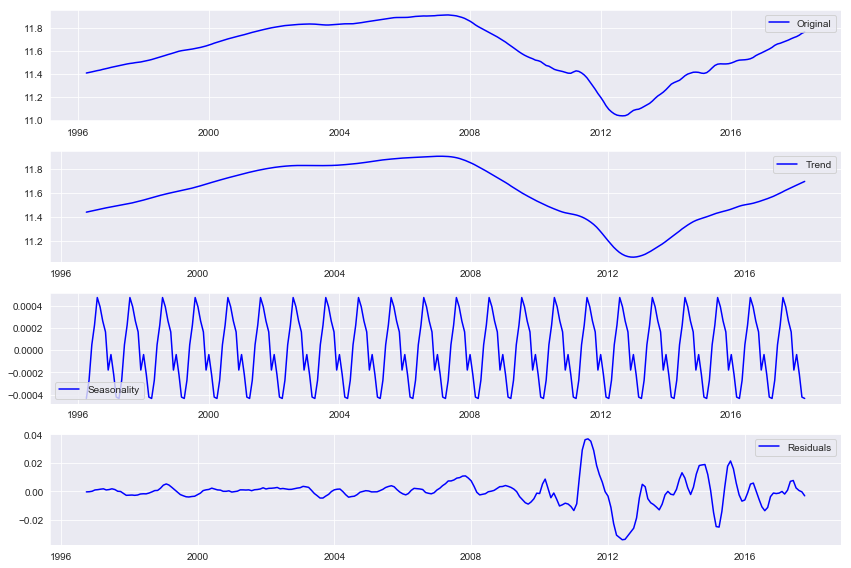

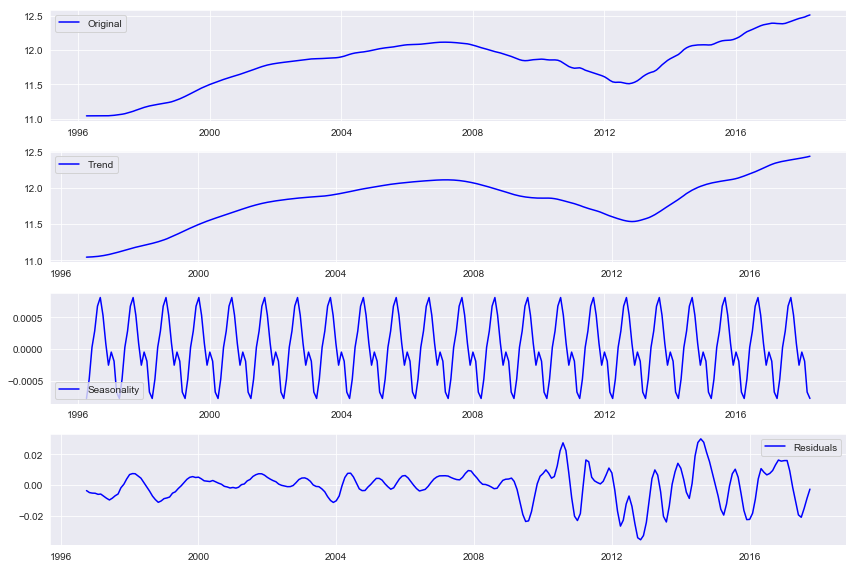

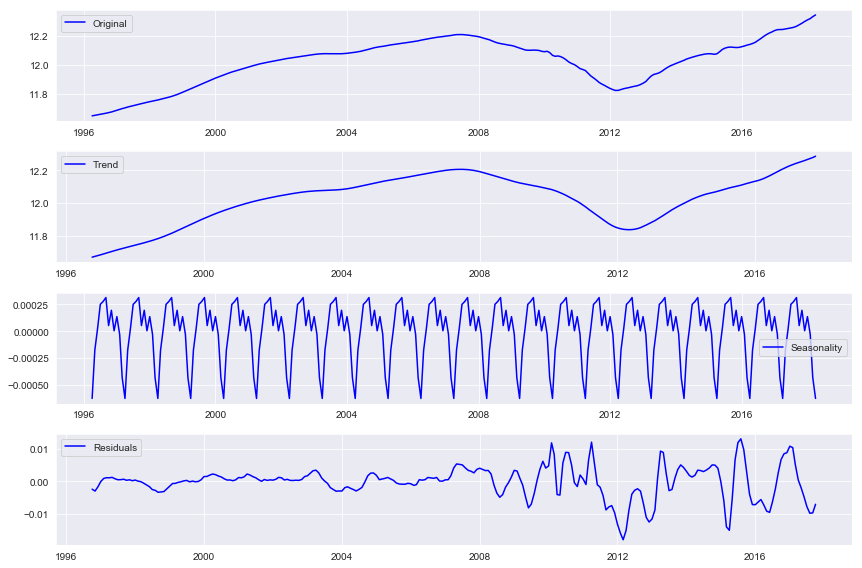

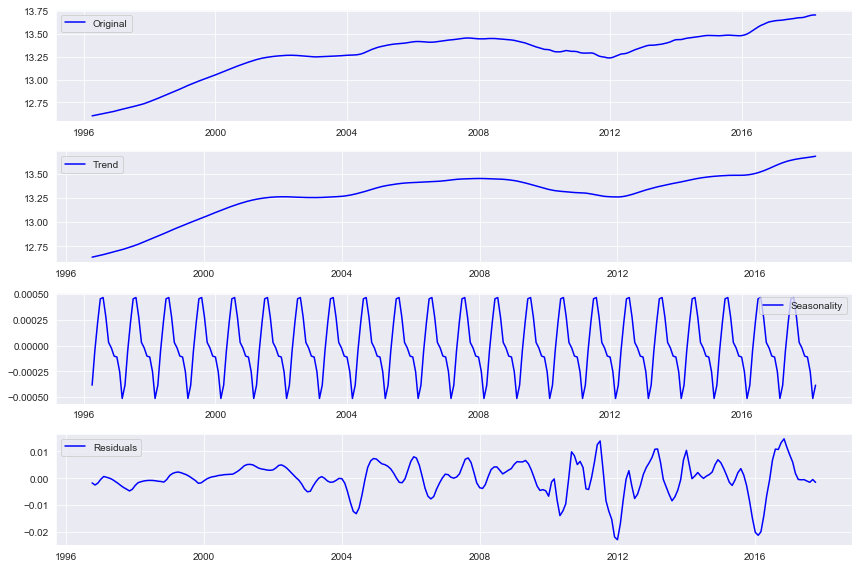

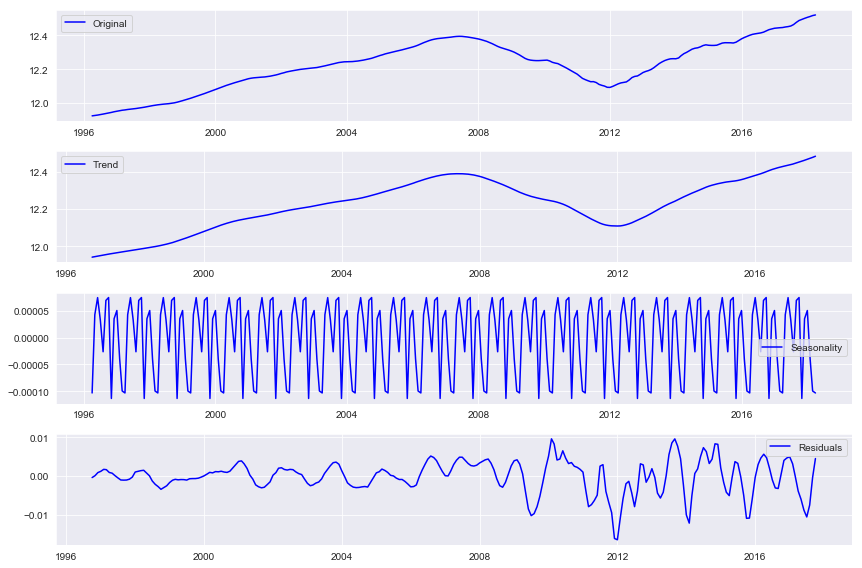

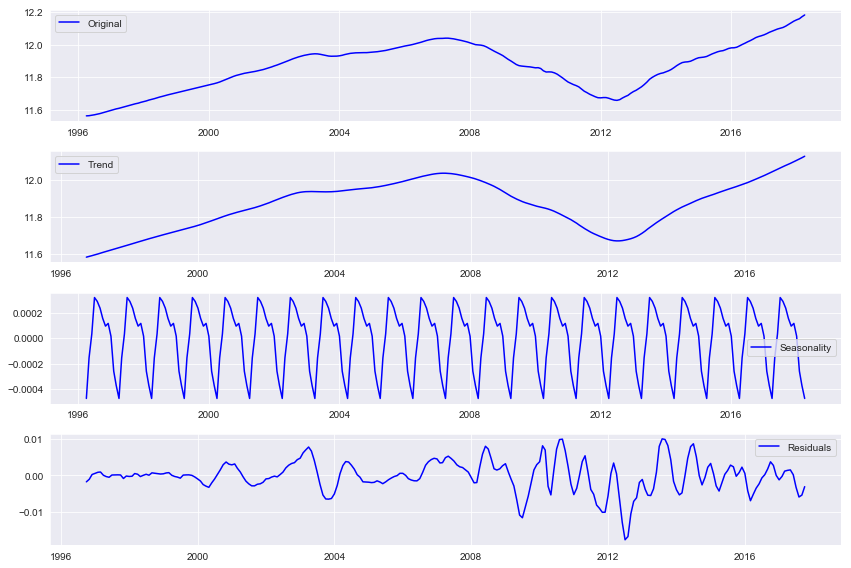

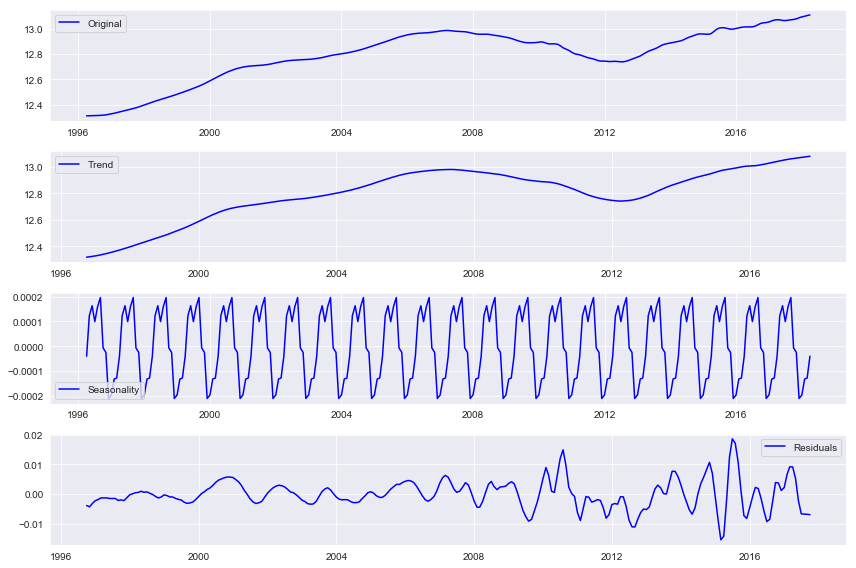

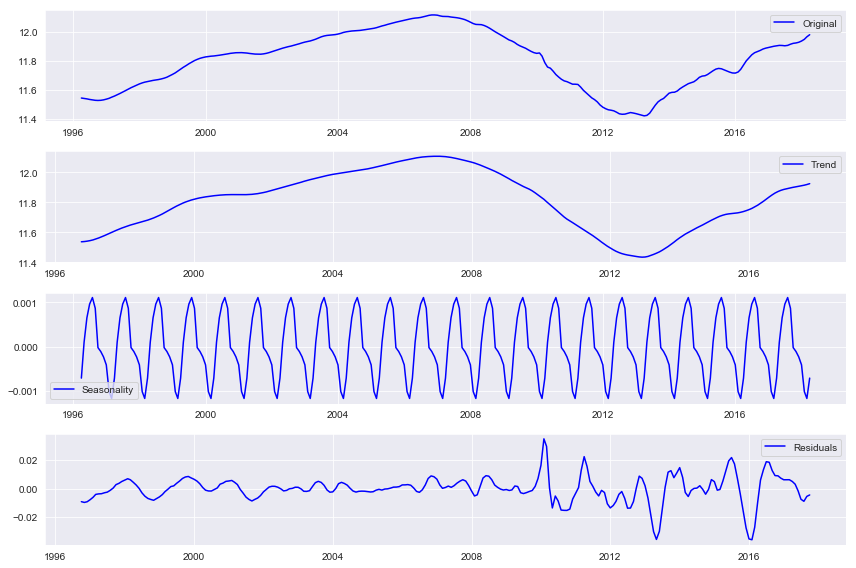

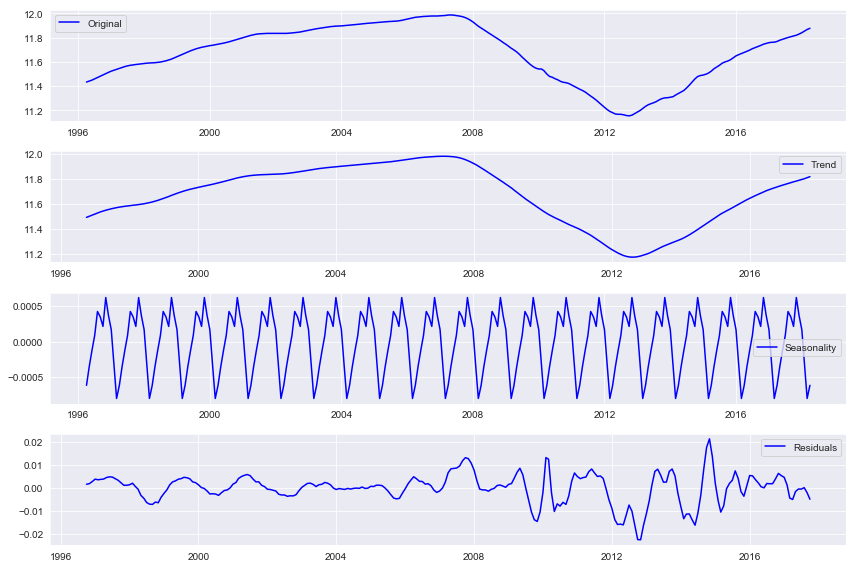

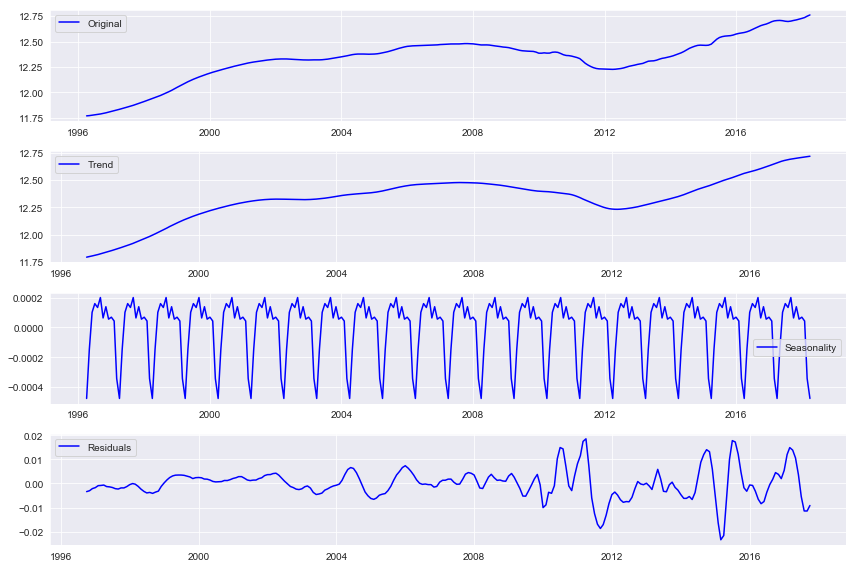

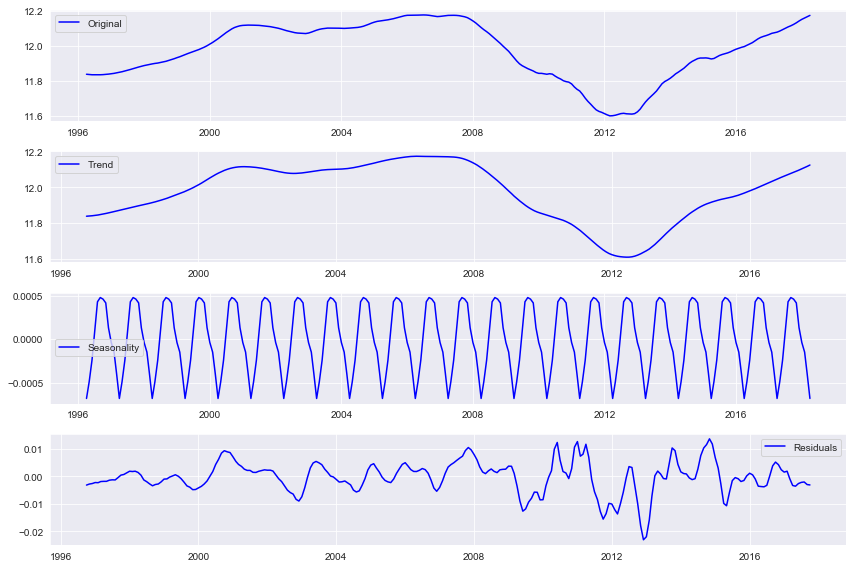

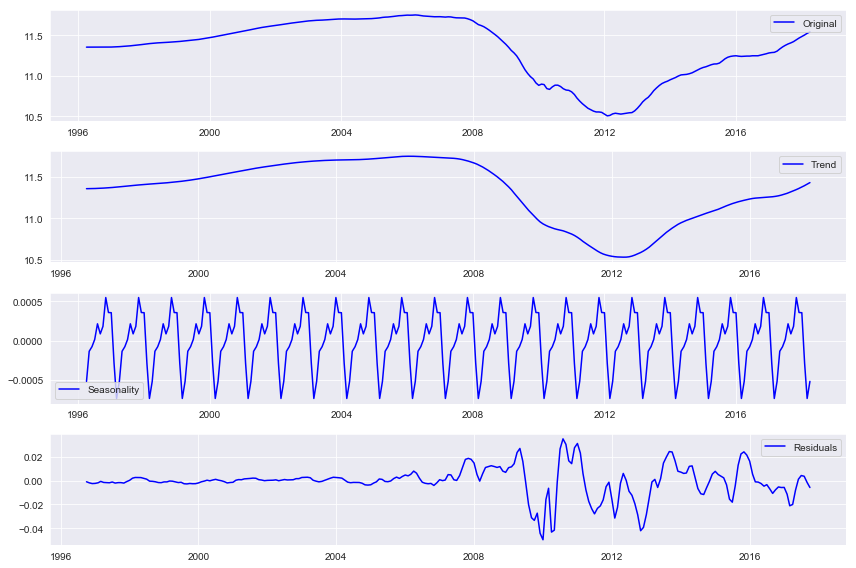

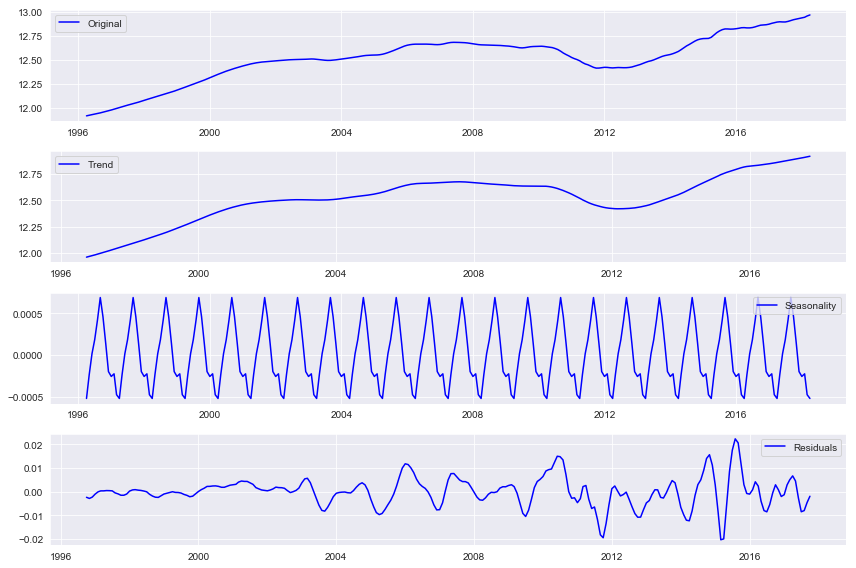

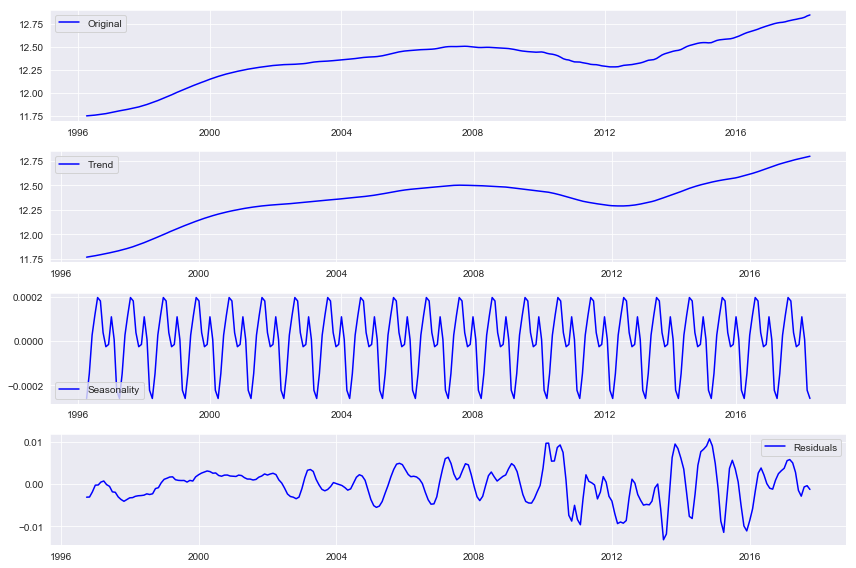

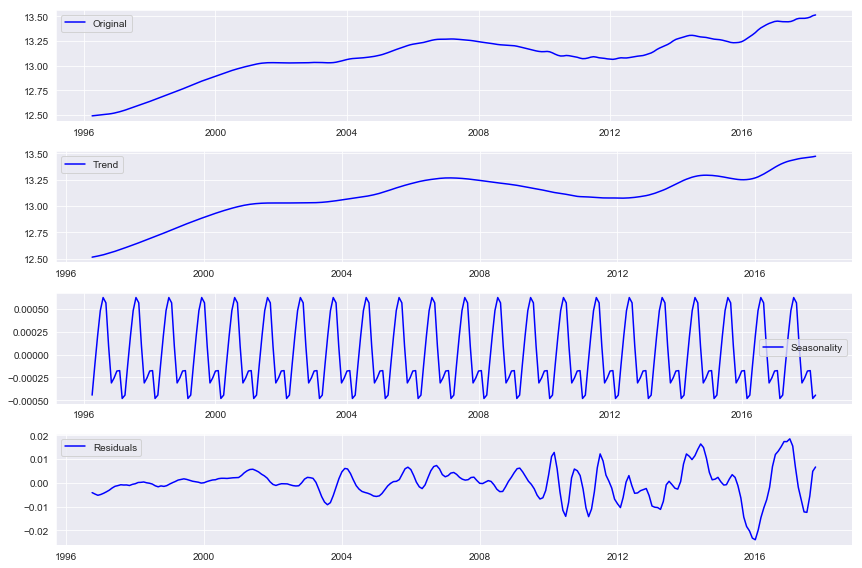

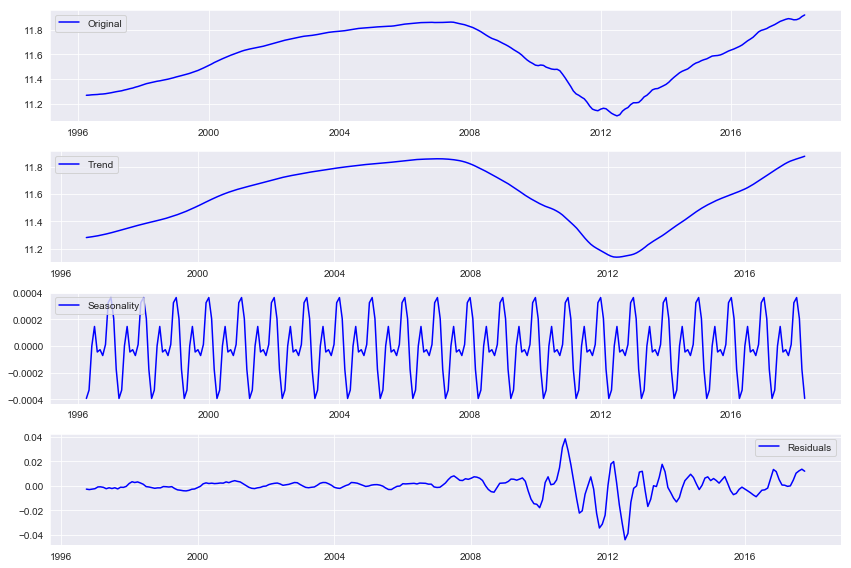

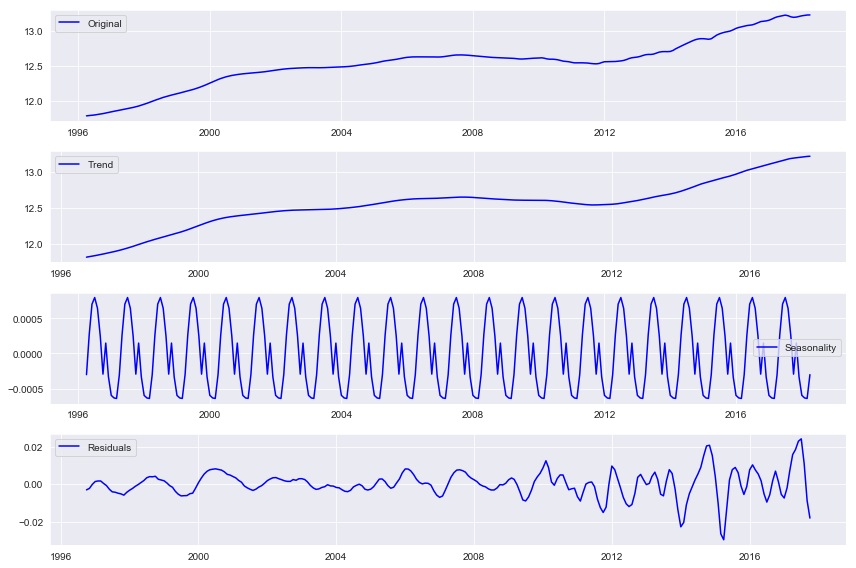

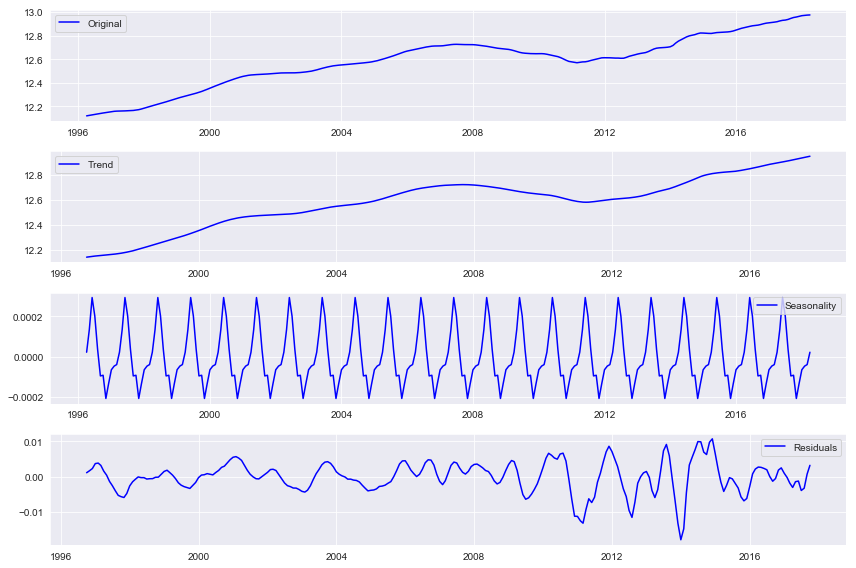

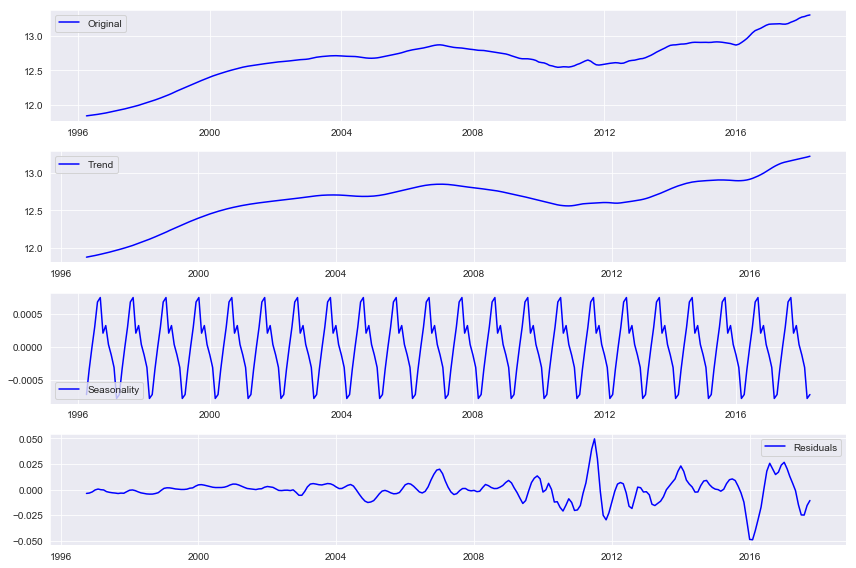

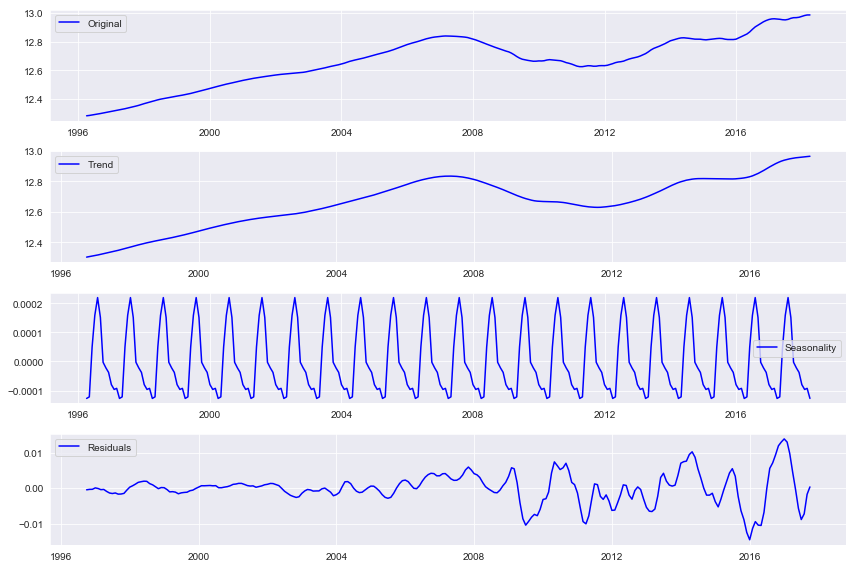

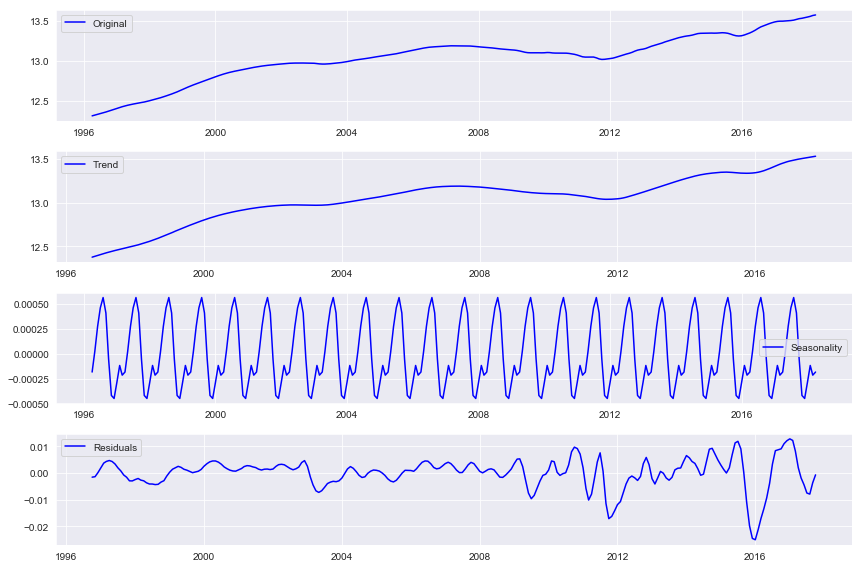

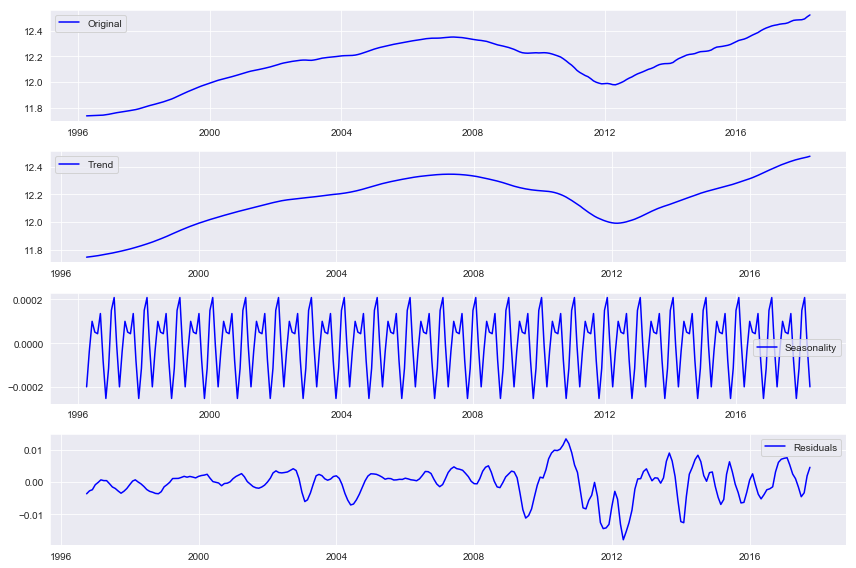

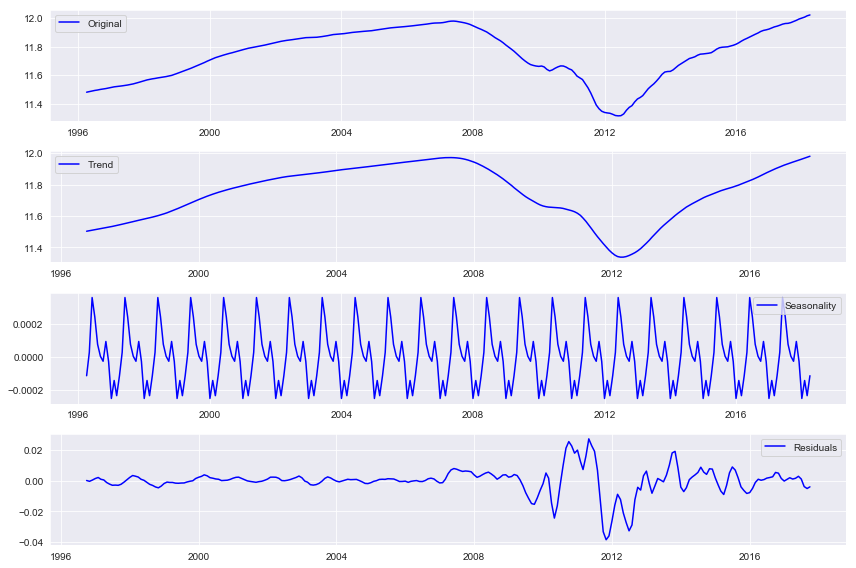

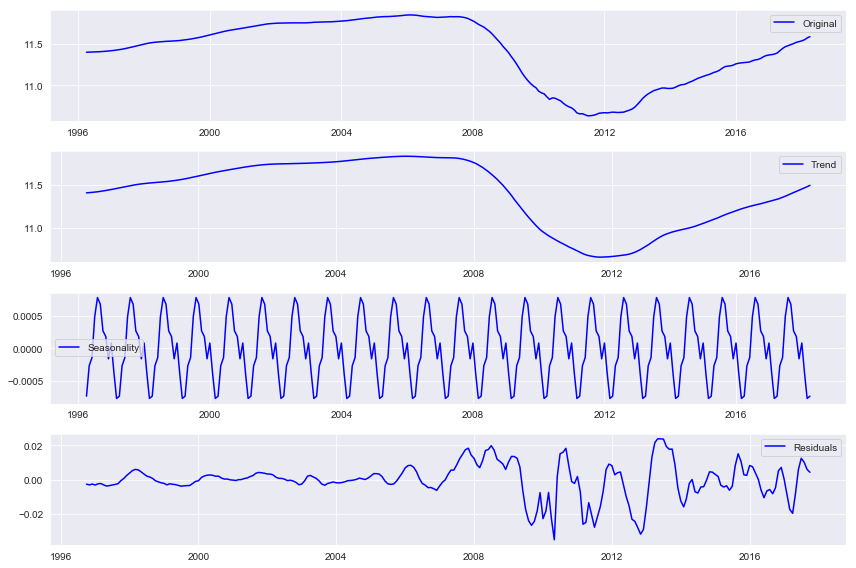

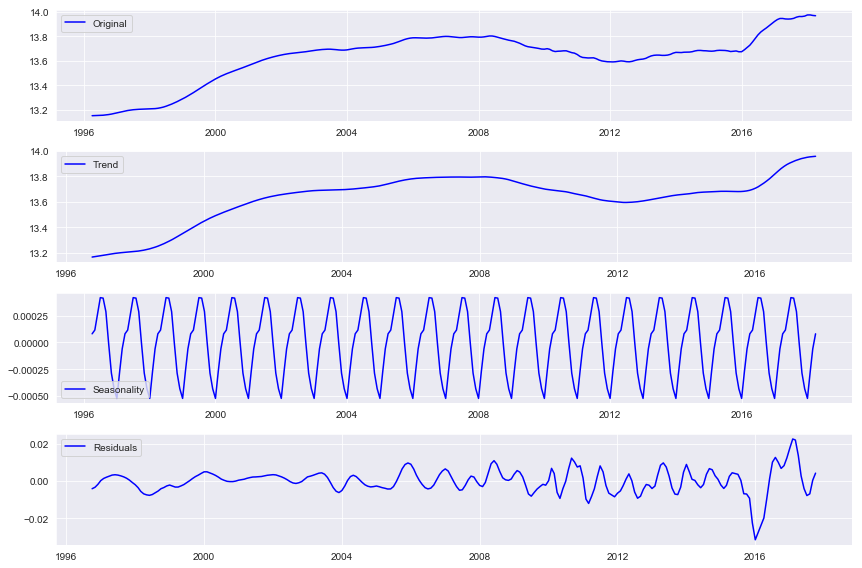

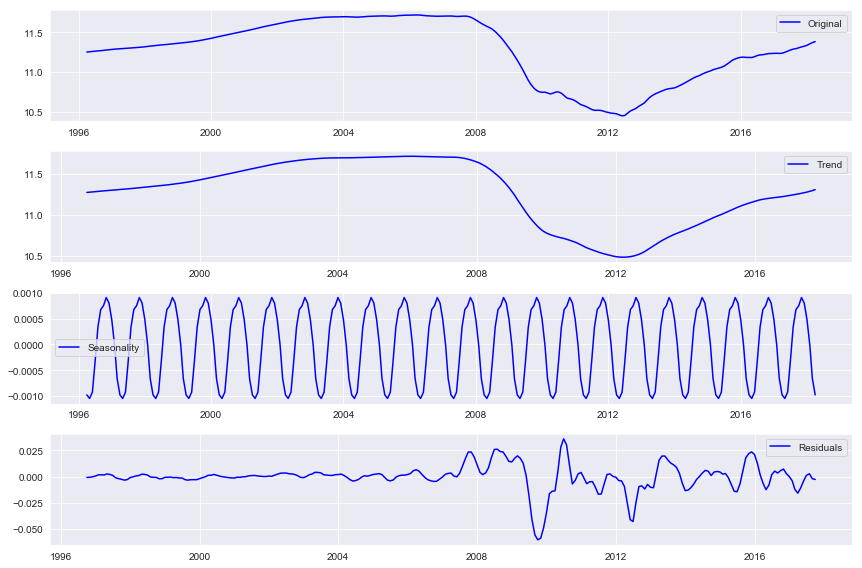

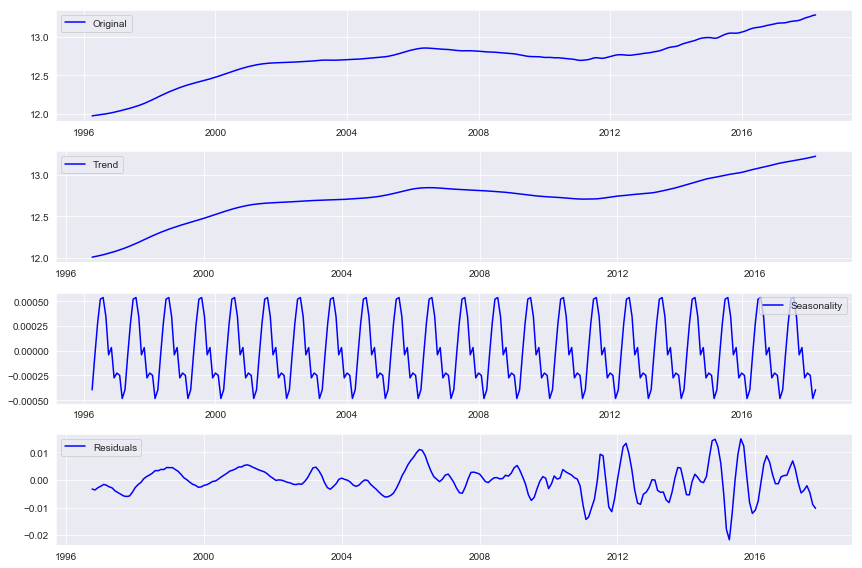

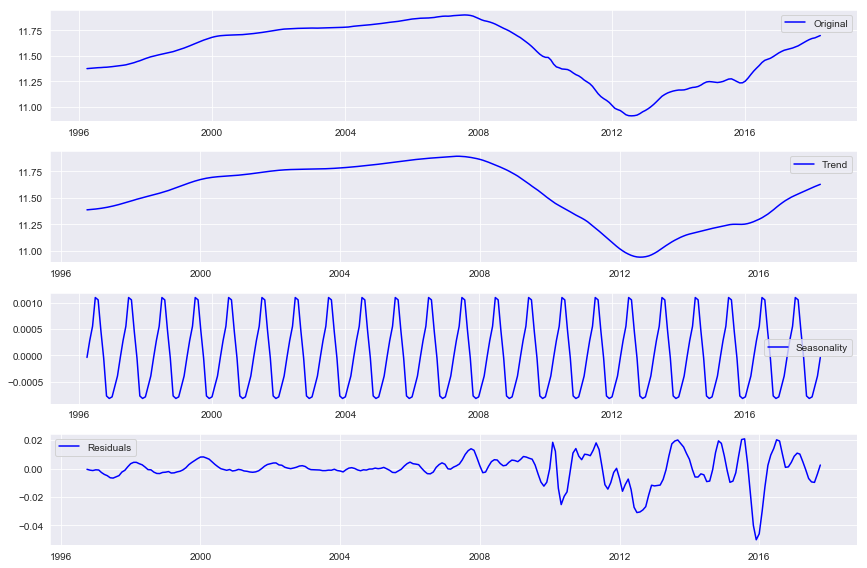

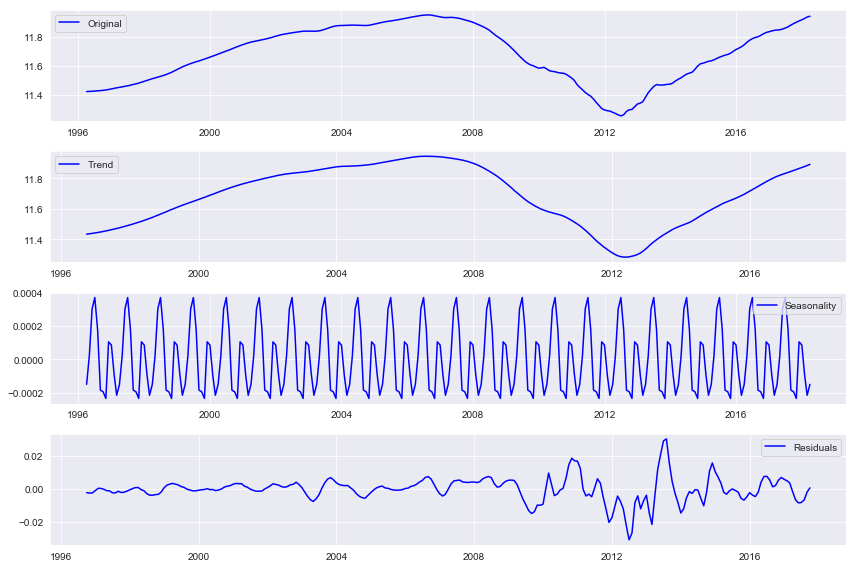

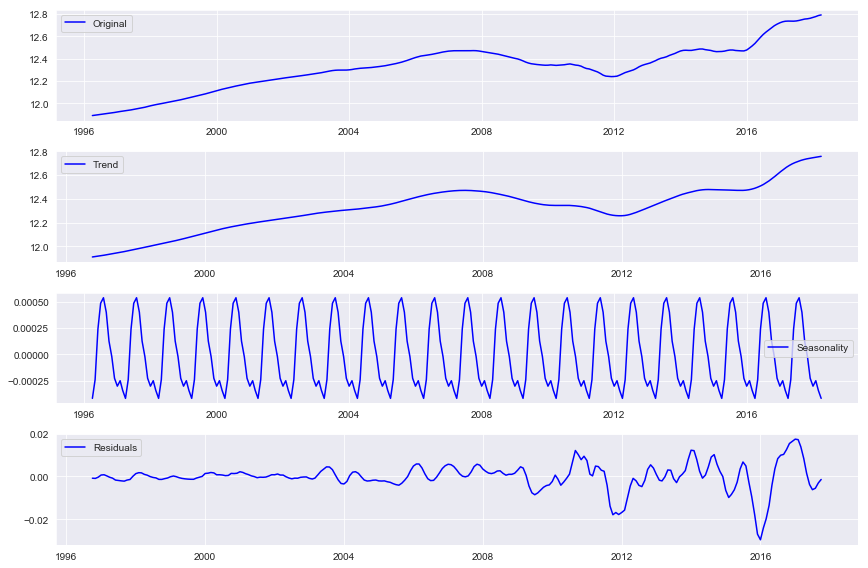

C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\matplotlib\axis.py:1081: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


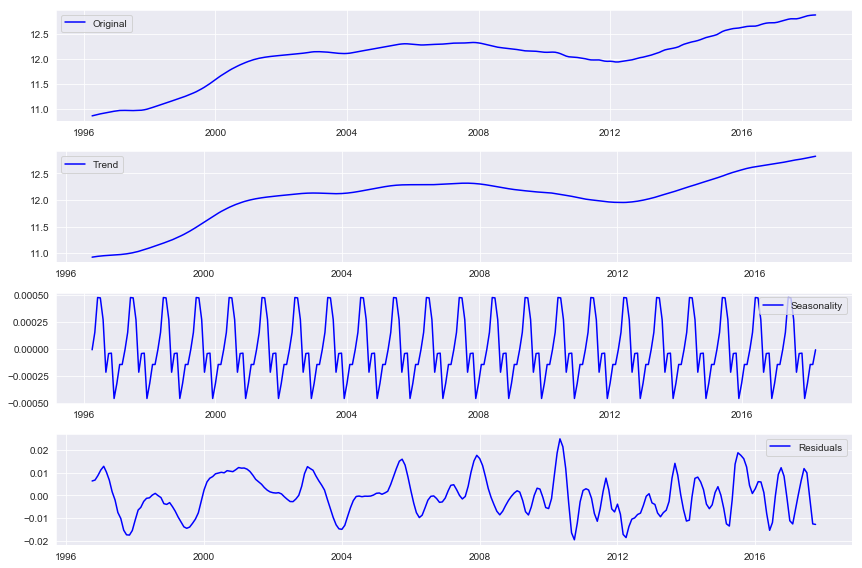

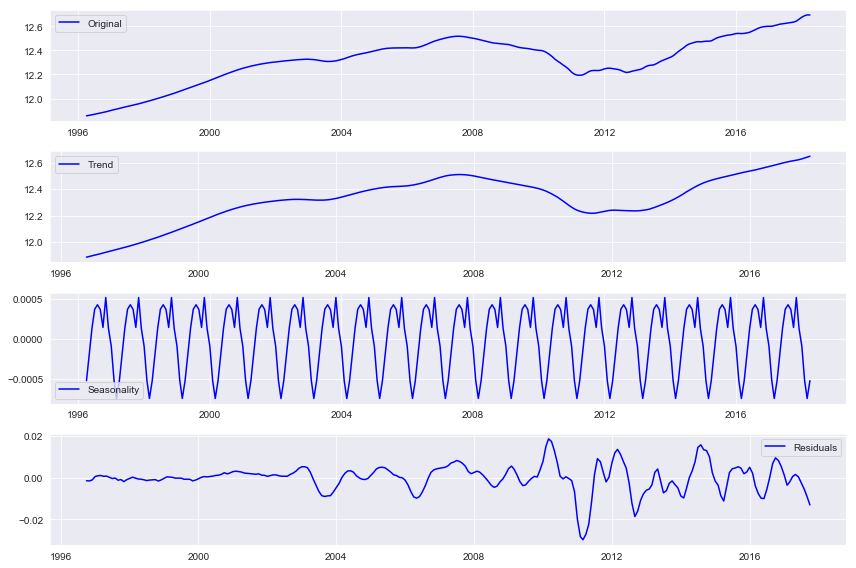

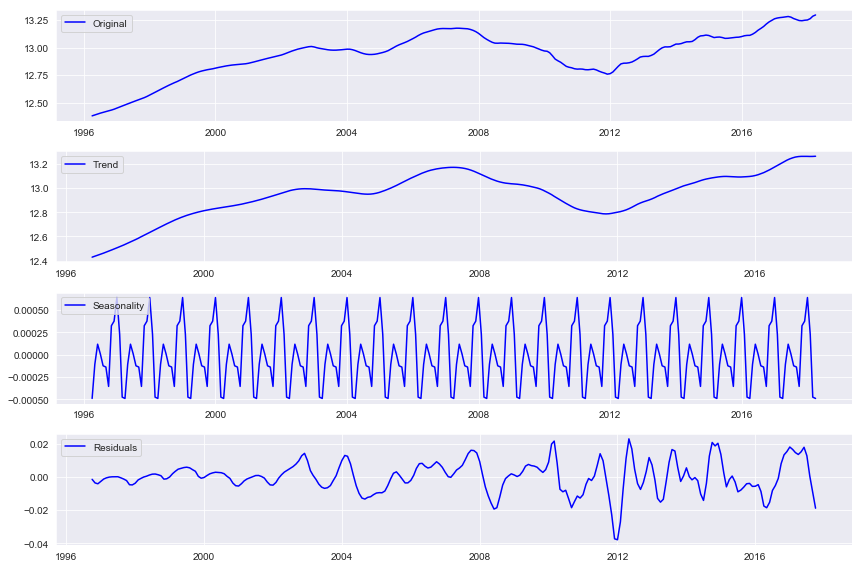

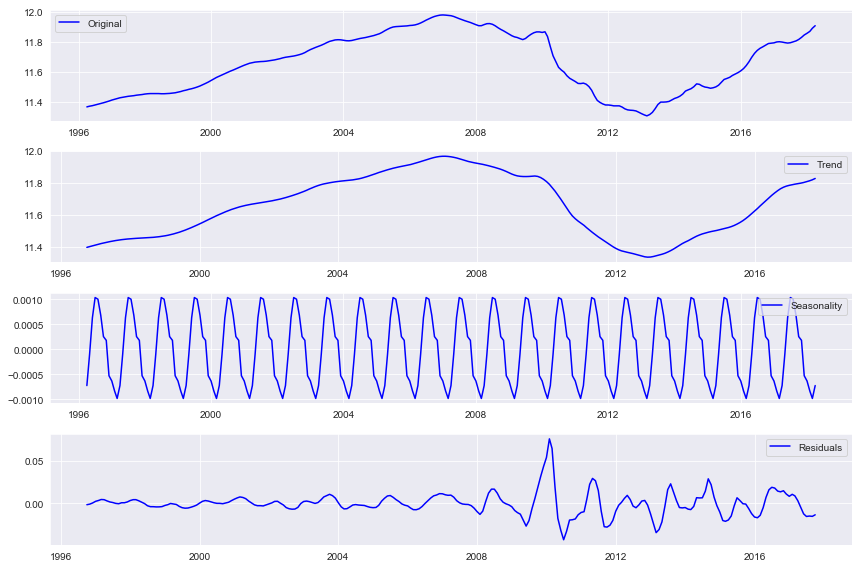

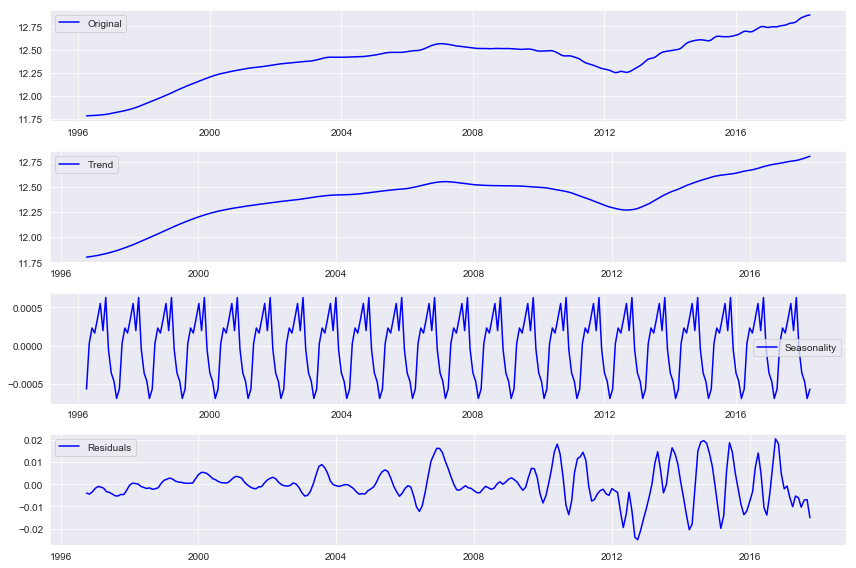

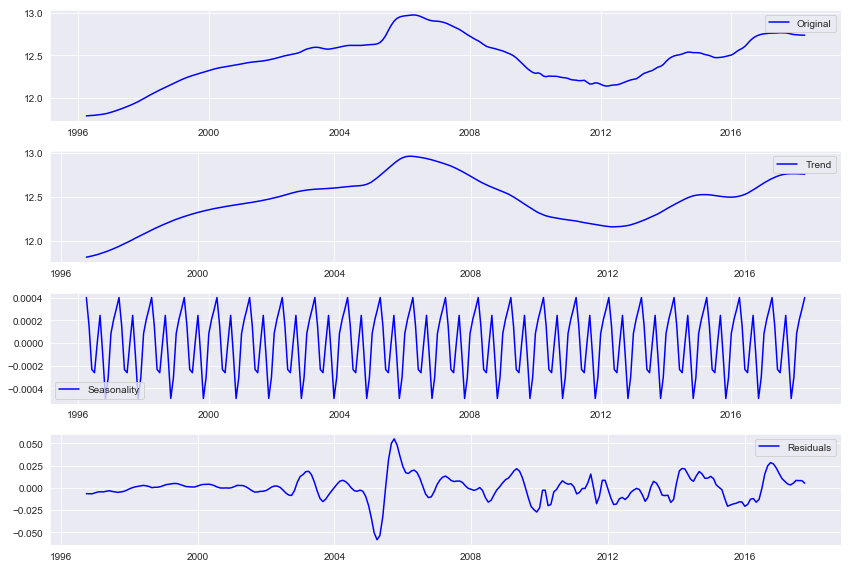

In [22]:
# decompose data for each zipcode
    
for zipcode in ATL_log.keys():
    decomposition = sd(ATL_log[zipcode])
    # Gather the trend, seasonality and noise of decomposed object
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot gathered statistics
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(ATL_log[zipcode], label='Original', color="blue")
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color="blue")
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonality', color="blue")
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color="blue")
    plt.legend(loc='best')
    plt.tight_layout();



# Step 6: Interpreting Results